## Imports and Data load

In [283]:
%pip install sweetviz
%pip install scikit-learn==1.1.3
%pip install catboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [284]:
import pandas as pd
import sweetviz as sv
import seaborn as sb
import numpy as np
import re
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import shuffle

from tqdm import tqdm
import matplotlib.pyplot as plt

In [285]:
train_data = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Titanic_kagle/Data/train.csv')
test_features = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Titanic_kagle/Data/test.csv')

test_target = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Titanic_kagle/Data/gender_submission.csv')

In [286]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [287]:
test_features.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## EDA

Let's write a simple function to quickly review data

In [288]:
def info_df(df):
    plt.figure(figsize=(15, 13))
    sb.heatmap(df.corr(), cmap="YlGnBu", annot=True);
    print('------------------------------')
    print('|    Dataset information.    |')
    print('------------------------------')
    df.info()
    print('------------------------------')
    print('|        First 10 rows.      |')
    print('------------------------------')
    print(df.head(10))
    print('---------------------------------')
    print('|        Last 10 rows.          |')
    print('---------------------------------')
    print(df.tail(10))
    print('---------------------------')
    print('| Descriptive statistics. |')
    print('---------------------------')
    print(df.describe())
    print('----------------------')
    print('| Sum of duplicates. |')
    print('----------------------')
    print(df.duplicated().sum())
    print('--------------------------')
    print('|    Covariance matrix.  |')
    print('--------------------------')
    plt.show()

------------------------------
|    Dataset information.    |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
------------------------------
|        First 10 rows.      |
------------------------------
   PassengerId  Survived  Pclass  \
0            1        

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_1419/924560989.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True);


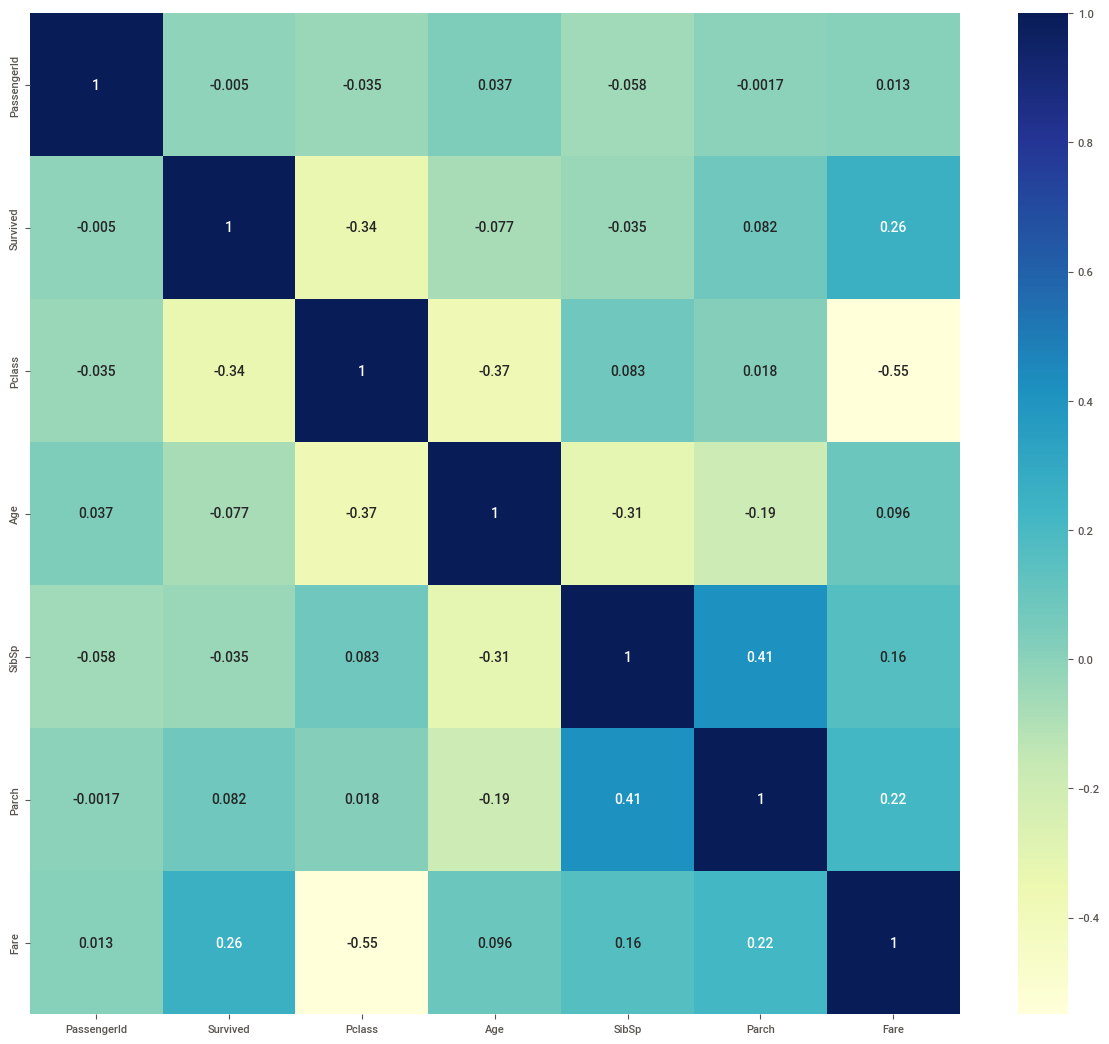

In [289]:
info_df(train_data)

In [290]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,19.900000
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_1419/924560989.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True);


------------------------------
|    Dataset information.    |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
------------------------------
|        First 10 rows.      |
------------------------------
   PassengerId  Pclass                                          Name     Sex  \
0          892      

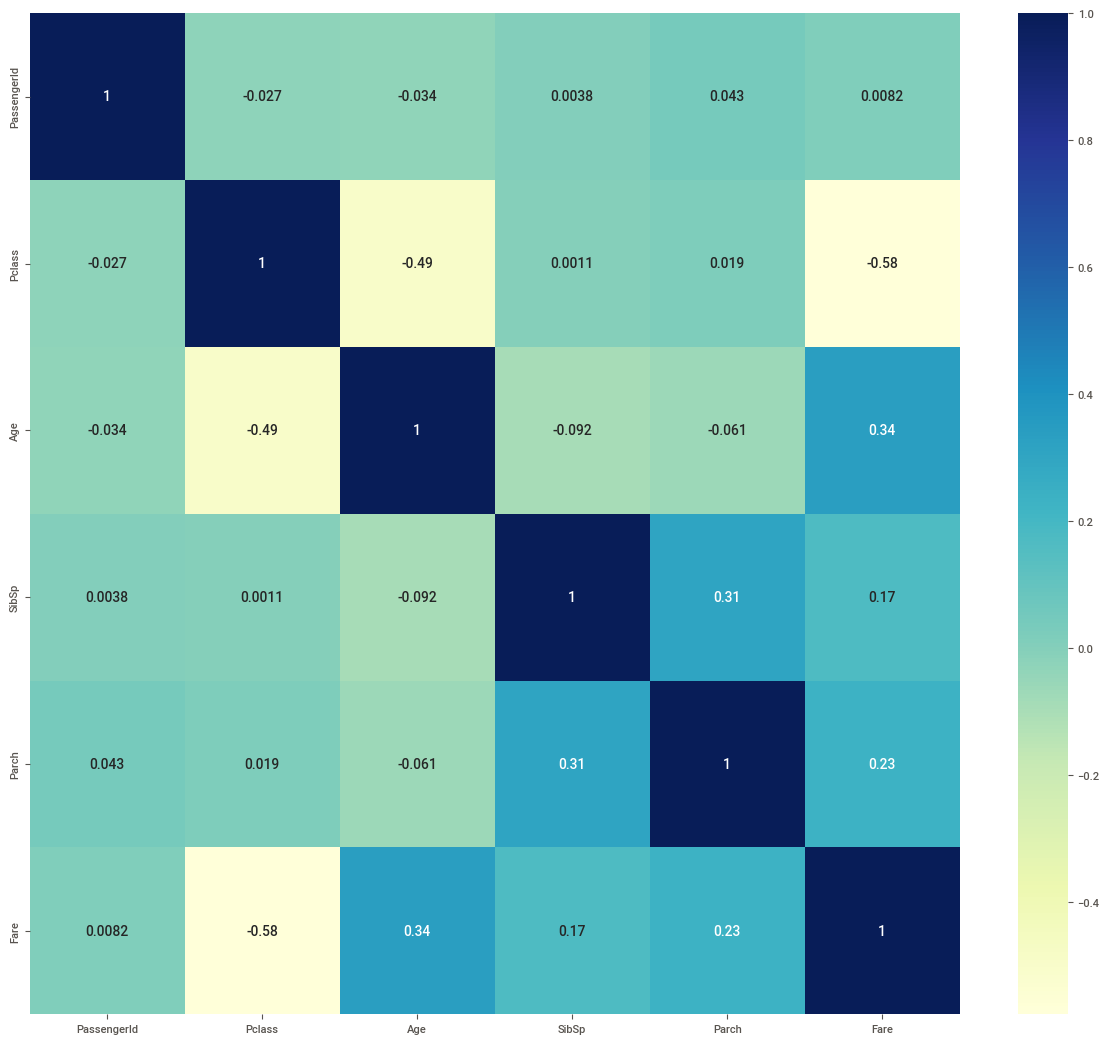

In [291]:
info_df(test_features)

In [292]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(test_features.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
PassengerId,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,20.600000
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.200000
Cabin,78.200000


We can see that in columns `Age`, `Cabin` and `Embarked` has a gaps in data. And also `Age` has a different data type (Float64). Let's make change to these mistakes!

**Rename titels**

In [293]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [294]:
columns = {}
for i in train_data.columns:
    columns[i] = i.lower()
train_data = train_data.rename(columns=columns)
test_features = test_features.rename(columns=columns)

**Duplicates**

In [295]:
train_data = train_data.drop('passengerid', axis = 1)
train_data.duplicated().sum()

0

In [296]:
test_features = test_features.drop('passengerid', axis = 1)
test_features.duplicated().sum()

0

**Implicit Duplicates**

Consider possible implicit duplicates

In [297]:
for i in ['sex', 'sibsp','ticket', 'cabin','embarked']:
    print(i)
    print('------------------------------------------------------------')
    print(train_data[i].unique())
    print('------------------------------------------------------------')

sex
------------------------------------------------------------
['male' 'female']
------------------------------------------------------------
sibsp
------------------------------------------------------------
[1 0 3 4 2 5 8]
------------------------------------------------------------
ticket
------------------------------------------------------------
['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151'
 '347082' '350406' '248706' '382652' '244373' '345763' '2649' '239865'
 '248698' '330923' '113788' '347077' '2631' '19950' '330959' '349216'
 'PC 17601' 'PC 17569' '335677' 'C.A. 24579' 'PC 17604' '113789' '2677'
 'A./5. 2152' '345764' '2651' '7546' '11668' '349253' 'SC/Paris 2123'
 '330958' 'S.C./A.4. 23567' '370371' '14311' '2662' '349237' '3101295'
 'A/4. 39886' 'PC 17572' '2926' '113509' '19947' 'C.A. 31026' '2697'
 'C.A. 34651' 'CA 2144' '2669' '113572' '36973' '347088' 'PC 17605' '2661'
 'C.A. 29

As you can see, tickets, cabin and embarker has a mistakes and ambiguity.

**Tickets**

First of all, let's have look on the tickets. We can replace code name and number of the tickets  and leave only number, because code name does not provide useful information. Also we can drop it, and... just do it, because, in my opinion, it is not useful information for our models, like a name.

P.S. In fact, there is useful information, but is this case i suggest relyimg on the type of cabin 

In [298]:
train_data = train_data.drop(['ticket','name'], axis = 1)
test_features = test_features.drop(['ticket','name'], axis = 1)

**Fill in the blanks**

I think its not a big deal and we can fill blanks the median value.

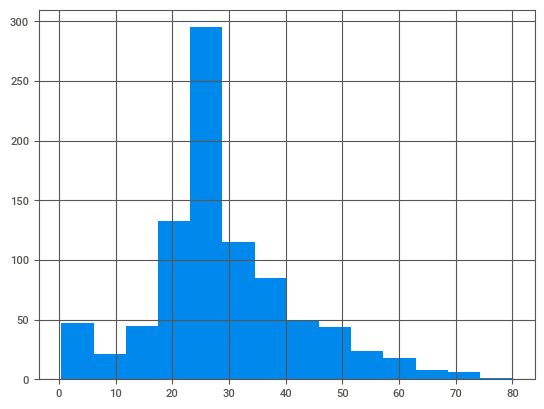

In [299]:
train_data['age'] = train_data['age'].fillna(train_data['age'].median())
train_data['age'].hist(bins=14);

**Cabin**

This point is ambiguous. Because the type of room really could affect survival. But we have a lot of gaps in this column. 

I suggest make a pivot table or just a look on dependency of data between type of room and passenger fare

But before that let's make a replace inplicit duplicates.

In [300]:
train_data['cabin'].sort_values().unique()

array(['A10', 'A14', 'A16', 'A19', 'A20', 'A23', 'A24', 'A26', 'A31',
       'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'B101', 'B102', 'B18',
       'B19', 'B20', 'B22', 'B28', 'B3', 'B30', 'B35', 'B37', 'B38',
       'B39', 'B4', 'B41', 'B42', 'B49', 'B5', 'B50', 'B51 B53 B55',
       'B57 B59 B63 B66', 'B58 B60', 'B69', 'B71', 'B73', 'B77', 'B78',
       'B79', 'B80', 'B82 B84', 'B86', 'B94', 'B96 B98', 'C101', 'C103',
       'C104', 'C106', 'C110', 'C111', 'C118', 'C123', 'C124', 'C125',
       'C126', 'C128', 'C148', 'C2', 'C22 C26', 'C23 C25 C27', 'C30',
       'C32', 'C45', 'C46', 'C47', 'C49', 'C50', 'C52', 'C54', 'C62 C64',
       'C65', 'C68', 'C7', 'C70', 'C78', 'C82', 'C83', 'C85', 'C86',
       'C87', 'C90', 'C91', 'C92', 'C93', 'C95', 'C99', 'D', 'D10 D12',
       'D11', 'D15', 'D17', 'D19', 'D20', 'D21', 'D26', 'D28', 'D30',
       'D33', 'D35', 'D36', 'D37', 'D45', 'D46', 'D47', 'D48', 'D49',
       'D50', 'D56', 'D6', 'D7', 'D9', 'E10', 'E101', 'E12', 'E121',
       'E17',

In [301]:
test_features['cabin'].sort_values().unique()

array(['A11', 'A18', 'A21', 'A29', 'A34', 'A9', 'B10', 'B11', 'B24',
       'B26', 'B36', 'B41', 'B45', 'B51 B53 B55', 'B52 B54 B56',
       'B57 B59 B63 B66', 'B58 B60', 'B61', 'B69', 'B71', 'B78', 'C101',
       'C105', 'C106', 'C116', 'C130', 'C132', 'C22 C26', 'C23 C25 C27',
       'C28', 'C31', 'C32', 'C39', 'C46', 'C51', 'C53', 'C54', 'C55 C57',
       'C6', 'C62 C64', 'C7', 'C78', 'C80', 'C85', 'C86', 'C89', 'C97',
       'D', 'D10 D12', 'D15', 'D19', 'D21', 'D22', 'D28', 'D30', 'D34',
       'D37', 'D38', 'D40', 'D43', 'E31', 'E34', 'E39 E41', 'E45', 'E46',
       'E50', 'E52', 'E60', 'F', 'F E46', 'F E57', 'F G63', 'F2', 'F33',
       'F4', 'G6', nan], dtype=object)

Right now we have a 3 ways.
- The first way, we can replace stuck together cabins on single type like B57 B59 etc. to B (median number).
- The second way, we can split this cabins, and attempt recover based on tickets.
- The thierd way, we can drop it. 

In your case choose you way. But i am choose the first.

In [302]:
train_data = train_data.apply(lambda x: x.replace({'C2 C2 C2':'C2', 'F G73': 'G73', 'F E69': 'E69',
                                                     'C2 C2':'C2', 'F G63': 'G63','B51 B53 B55': 'B53', 
                                                     'B57 B59 B63 B66': 'B61', 'B58 B60': 'B59', 'B82 B84': 'B81', 
                                                     'B96 B98': 'B97', 'C62 C64': 'C63', 'D10 D12': 'D11',
                                                     'C22 C26': 'C24', 'C23 C25 C27': 'C25'}, regex=True))

In [303]:
test_features = test_features.apply(lambda x: x.replace({'B51 B53 B55': 'B53', 'B52 B54 B56': 'B54', 
                                                         'B57 B59 B63 B66': 'B61','B58 B60': 'B59', 'C22 C26': 'C24',
                                                         'C23 C25 C27': 'C25','C55 C57':'C56','C62 C64': 'C63', 
                                                         'D10 D12': 'D11', 'E39 E41': 'E40', 'F E46': 'E46', 'F E57': 'E57',
                                                         'F G63': 'G63'}, regex=True))

In [304]:
train_data = train_data.dropna()

In [305]:
train_data['cabin'].sort_values().unique()

array(['A10', 'A14', 'A16', 'A19', 'A20', 'A23', 'A24', 'A26', 'A31',
       'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'B101', 'B102', 'B18',
       'B19', 'B20', 'B22', 'B3', 'B30', 'B35', 'B37', 'B38', 'B39', 'B4',
       'B41', 'B42', 'B49', 'B5', 'B50', 'B53', 'B59', 'B61', 'B69',
       'B71', 'B73', 'B77', 'B78', 'B79', 'B80', 'B81', 'B86', 'B94',
       'B97', 'C101', 'C103', 'C104', 'C106', 'C110', 'C111', 'C118',
       'C123', 'C124', 'C125', 'C126', 'C128', 'C148', 'C2', 'C24', 'C25',
       'C30', 'C32', 'C45', 'C46', 'C47', 'C49', 'C50', 'C52', 'C54',
       'C63', 'C65', 'C68', 'C7', 'C70', 'C78', 'C82', 'C83', 'C85',
       'C86', 'C87', 'C90', 'C91', 'C92', 'C93', 'C95', 'C99', 'D', 'D11',
       'D15', 'D17', 'D19', 'D20', 'D21', 'D26', 'D28', 'D30', 'D33',
       'D35', 'D36', 'D37', 'D45', 'D46', 'D47', 'D48', 'D49', 'D50',
       'D56', 'D6', 'D7', 'D9', 'E10', 'E101', 'E12', 'E121', 'E17',
       'E24', 'E25', 'E31', 'E33', 'E34', 'E36', 'E38', 'E40', 'E44',
       'E

In [306]:
test_features['cabin'].sort_values().unique()

array(['A11', 'A18', 'A21', 'A29', 'A34', 'A9', 'B10', 'B11', 'B24',
       'B26', 'B36', 'B41', 'B45', 'B53', 'B54', 'B59', 'B61', 'B69',
       'B71', 'B78', 'C101', 'C105', 'C106', 'C116', 'C130', 'C132',
       'C24', 'C25', 'C28', 'C31', 'C32', 'C39', 'C46', 'C51', 'C53',
       'C54', 'C56', 'C6', 'C63', 'C7', 'C78', 'C80', 'C85', 'C86', 'C89',
       'C97', 'D', 'D11', 'D15', 'D19', 'D21', 'D22', 'D28', 'D30', 'D34',
       'D37', 'D38', 'D40', 'D43', 'E31', 'E34', 'E40', 'E45', 'E46',
       'E50', 'E52', 'E57', 'E60', 'F', 'F2', 'F33', 'F4', 'G6', 'G63',
       nan], dtype=object)

Let's separate the cabin type and cabin number and create two new  features.

In [307]:
def split_test_cabin_type(row):
    if row:
        return re.findall(r'[a-zA-Z]+',str(row))[0]
    else:
        pass

In [308]:
def split_test_cabin_number(row):
    if pd.notna(row) and len(row) > 1:
        return int(row[1:])
    else:
        pass

In [309]:
train_data['type_cabin'] = train_data['cabin'].apply(lambda str: re.findall(r'[a-zA-Z]+',str)[0])
train_data['number_cabin'] = train_data['cabin'].apply(lambda str: int(*(re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?",str))))


test_features['type_cabin'] = test_features['cabin'].apply(split_test_cabin_type)
test_features['number_cabin'] = test_features['cabin'].apply(split_test_cabin_number)

In [310]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202 entries, 1 to 889
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   survived      202 non-null    int64  
 1   pclass        202 non-null    int64  
 2   sex           202 non-null    object 
 3   age           202 non-null    float64
 4   sibsp         202 non-null    int64  
 5   parch         202 non-null    int64  
 6   fare          202 non-null    float64
 7   cabin         202 non-null    object 
 8   embarked      202 non-null    object 
 9   type_cabin    202 non-null    object 
 10  number_cabin  202 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 18.9+ KB


In [311]:
train_data['type_cabin']

1      C
3      C
6      E
10     G
11     C
      ..
871    D
872    B
879    C
887    B
889    C
Name: type_cabin, Length: 202, dtype: object

In [312]:
train_data['number_cabin']

1       85
3      123
6       46
10       6
11     103
      ... 
871     35
872     53
879     50
887     42
889    148
Name: number_cabin, Length: 202, dtype: int64

In [313]:
train_data = train_data.drop('cabin', axis = 1)
train_data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,type_cabin,number_cabin
1,1,1,female,38.0,1,0,71.2833,C,C,85
3,1,1,female,35.0,1,0,53.1000,S,C,123
6,0,1,male,54.0,0,0,51.8625,S,E,46
10,1,3,female,4.0,1,1,16.7000,S,G,6
11,1,1,female,58.0,0,0,26.5500,S,C,103
...,...,...,...,...,...,...,...,...,...,...
871,1,1,female,47.0,1,1,52.5542,S,D,35
872,0,1,male,33.0,0,0,5.0000,S,B,53
879,1,1,female,56.0,0,1,83.1583,C,C,50
887,1,1,female,19.0,0,0,30.0000,S,B,42


In [314]:
test_features = test_features.drop('cabin', axis = 1)
test_features

,pclass,sex,age,sibsp,parch,fare,embarked,type_cabin,number_cabin
0,3,male,34.5,0,0,7.8292,Q,nan,NaN
1,3,female,47.0,1,0,7.0000,S,nan,NaN
2,2,male,62.0,0,0,9.6875,Q,nan,NaN
3,3,male,27.0,0,0,8.6625,S,nan,NaN
4,3,female,22.0,1,1,12.2875,S,nan,NaN
...,...,...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S,nan,NaN
414,1,female,39.0,0,0,108.9000,C,C,105.0
415,3,male,38.5,0,0,7.2500,S,nan,NaN
416,3,male,NaN,0,0,8.0500,S,nan,NaN


**Convert Float to Int and Int to Int**

This point in particularly not important, but i wanna say, that you need learn save you RAM.

In [315]:
train_data[['survived', 'pclass', 'sibsp', 'parch', 'age']] = train_data[['survived', 'pclass', 'sibsp', 'parch', 'age']].astype('int16')
test_features[['pclass', 'sibsp', 'parch', 'age']] = pd.notna(test_features[['pclass', 'sibsp', 'parch', 'age']]).astype('int16')

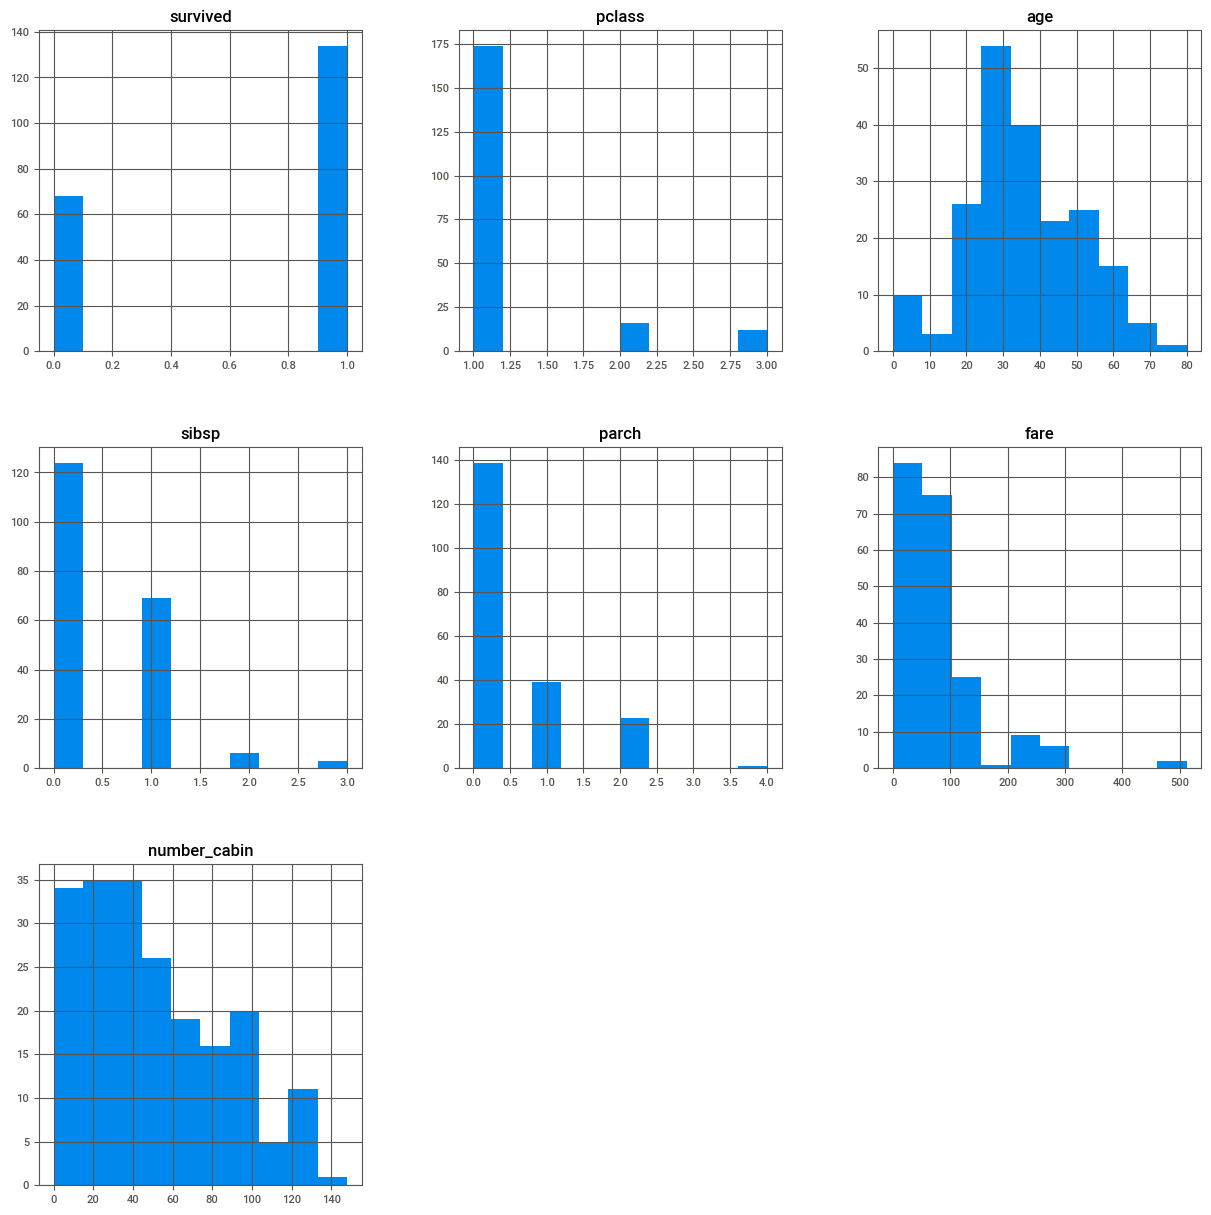

In [316]:
train_data.hist(figsize=(15,15));

In [317]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
survived,0.000000
pclass,0.000000
sex,0.000000
age,0.000000
sibsp,0.000000
parch,0.000000
fare,0.000000
embarked,0.000000
type_cabin,0.000000
number_cabin,0.000000


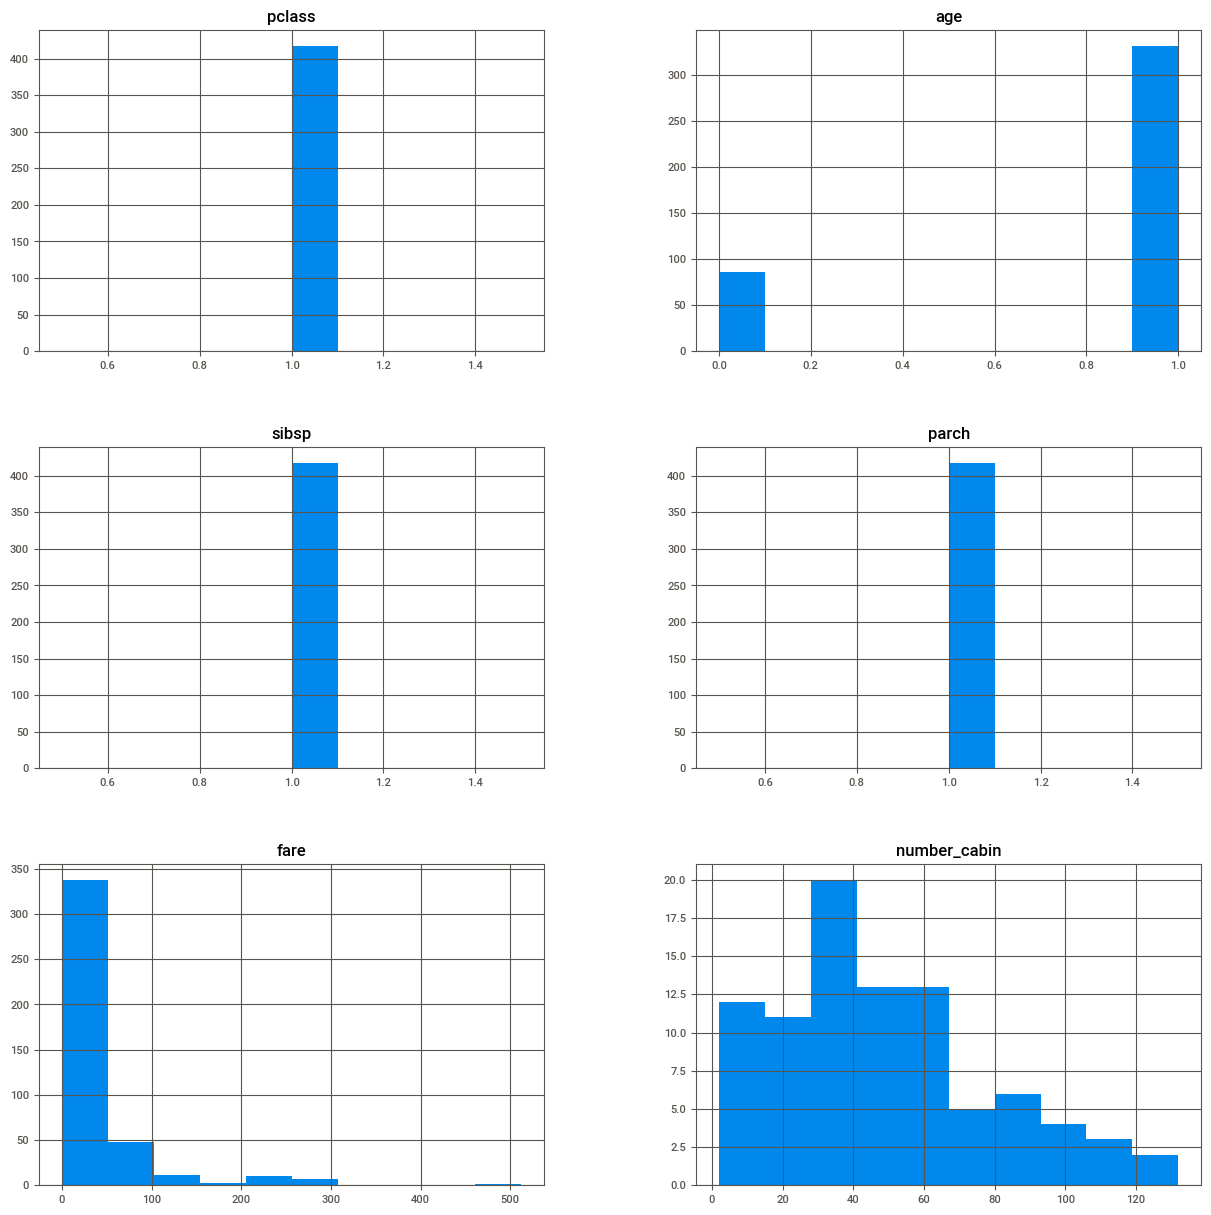

In [318]:
test_features.hist(figsize=(15,15));

In [319]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(test_features.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
pclass,0.000000
sex,0.000000
age,0.000000
sibsp,0.000000
parch,0.000000
fare,0.200000
embarked,0.000000
type_cabin,0.000000
number_cabin,78.700000


In [320]:
train_report = sv.analyze(train_data)
test_report = sv.analyze(test_features)

/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same 

                                             |          | [  0%]   00:00 -> (? left)

/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item 

In [321]:
train_report.show_html('Train_report.html')
test_report.show_html('Test_report.html')

Report Train_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Report Test_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Feature Preparation

In this project we are will be use library CatBoost. CatBoost is a machine learning algorithm that uses gradient boosting on decision trees. It is available as an open source library.

In [322]:
features = train_data.drop('survived', axis = 1)
target = train_data['survived']
test_target_ml = test_target['Survived'] 

In [323]:
train_features, validation_features, train_targte, validation_target = \
train_test_split(features, target, train_size=0.75, random_state=0)

In [324]:
cat_features = ohe_features = features.select_dtypes(include='object').columns.to_list()
cat_features

['sex', 'embarked', 'type_cabin']

In [325]:
model = CatBoostClassifier(
    iterations=100,
    custom_loss=[metrics.Accuracy()],
    random_seed=42
)

In [326]:
model.fit(
    train_features, train_targte,
    cat_features=cat_features,
    eval_set=(test_features, test_target_ml),
    plot=True,
    verbose=10
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.05409
0:	learn: 0.6839148	test: 0.6850590	best: 0.6850590 (0)	total: 868us	remaining: 86ms
10:	learn: 0.5841976	test: 0.6578477	best: 0.6578477 (10)	total: 5.78ms	remaining: 46.7ms
20:	learn: 0.5231649	test: 0.6857969	best: 0.6470091 (13)	total: 10.5ms	remaining: 39.3ms
30:	learn: 0.4820771	test: 0.7208704	best: 0.6470091 (13)	total: 18.9ms	remaining: 42.2ms
40:	learn: 0.4458831	test: 0.7551805	best: 0.6470091 (13)	total: 27.8ms	remaining: 40ms
50:	learn: 0.4189199	test: 0.7738216	best: 0.6470091 (13)	total: 35.9ms	remaining: 34.5ms
60:	learn: 0.4005008	test: 0.7790682	best: 0.6470091 (13)	total: 40.6ms	remaining: 26ms
70:	learn: 0.3837728	test: 0.7912555	best: 0.6470091 (13)	total: 45.5ms	remaining: 18.6ms
80:	learn: 0.3674747	test: 0.7975894	best: 0.6470091 (13)	total: 50.2ms	remaining: 11.8ms
90:	learn: 0.3521562	test: 0.8208553	best: 0.6470091 (13)	total: 55.8ms	remaining: 5.52ms
99:	learn: 0.3407057	test: 0.8283370	best: 0.6470091 (13)	total: 59.9ms	remainin

In [327]:
cv_params = model.get_params()
cv_params.update({
    'loss_function': metrics.Logloss()
})
cv_data = cv(
    Pool(features, target, cat_features=cat_features),
    cv_params,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]
0:	learn: 0.6682866	test: 0.6677755	best: 0.6677755 (0)	total: 5.01ms	remaining: 496ms
1:	learn: 0.6510270	test: 0.6516005	best: 0.6516005 (1)	total: 9.55ms	remaining: 468ms
2:	learn: 0.6338265	test: 0.6350527	best: 0.6350527 (2)	total: 13.7ms	remaining: 442ms
3:	learn: 0.6142551	test: 0.6164441	best: 0.6164441 (3)	total: 16.9ms	remaining: 406ms
4:	learn: 0.5987477	test: 0.6043014	best: 0.6043014 (4)	total: 21.4ms	remaining: 407ms
5:	learn: 0.5832182	test: 0.5898857	best: 0.5898857 (5)	total: 24.9ms	remaining: 391ms
6:	learn: 0.5707561	test: 0.5774918	best: 0.5774918 (6)	total: 26.5ms	remaining: 353ms
7:	learn: 0.5582177	test: 0.5651903	best: 0.5651903 (7)	total: 28.6ms	remaining: 329ms
8:	learn: 0.5477083	test: 0.5558928	best: 0.5558928 (8)	total: 29.8ms	remaining: 301ms
9:	learn: 0.5385604	test: 0.5520485	best: 0.5520485 (9)	total: 30.9ms	remaining: 278ms
10:	learn: 0.5264554	test: 0.5400704	best: 0.5400704 (10)	total: 32.8ms	remaining: 265ms
11:	learn: 0.51685

In [328]:
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.77±0.04 on step 48


In [329]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.7722816399286988


In [330]:
predictions = model.predict(test_features)
predictions_probs = model.predict_proba(test_features)
print(predictions[:10])
print(predictions_probs[:10])

[1 1 1 1 1 1 1 1 1 1]
[[0.48394921 0.51605079]
 [0.40669164 0.59330836]
 [0.48394921 0.51605079]
 [0.48394921 0.51605079]
 [0.39273022 0.60726978]
 [0.48394921 0.51605079]
 [0.40669164 0.59330836]
 [0.45932925 0.54067075]
 [0.40669164 0.59330836]
 [0.46784907 0.53215093]]


In [331]:
params = {
    'iterations': 500,
    'learning_rate': 0.1,
    'eval_metric': metrics.Accuracy(),
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': False
}
train_pool = Pool(features, target, cat_features=cat_features)
validate_pool = Pool(test_features, test_target_ml, cat_features=cat_features)

In [332]:
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

best_model_params = params.copy()
best_model_params.update({
    'use_best_model': True
})
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(test_target_ml, model.predict(test_features))
))
print('')

print('Best model validation accuracy: {:.4}'.format(
    accuracy_score(test_target_ml, best_model.predict(test_features))
))

Simple model validation accuracy: 0.3158

Best model validation accuracy: 0.4785


In [333]:
%%time
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

CPU times: user 1.02 s, sys: 1.03 s, total: 2.05 s
Wall time: 477 ms


In [334]:
%%time
earlystop_params = params.copy()
earlystop_params.update({
    'od_type': 'Iter',
    'od_wait': 40
})
earlystop_model = CatBoostClassifier(**earlystop_params)
earlystop_model.fit(train_pool, eval_set=validate_pool);

CPU times: user 84.1 ms, sys: 85.1 ms, total: 169 ms
Wall time: 41.8 ms


In [335]:
print('Simple model tree count: {}'.format(model.tree_count_))
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(test_target_ml, model.predict(test_features))
))
print('')

print('Early-stopped model tree count: {}'.format(earlystop_model.tree_count_))
print('Early-stopped model validation accuracy: {:.4}'.format(
    accuracy_score(test_target_ml, earlystop_model.predict(test_features))
))

Simple model tree count: 500
Simple model validation accuracy: 0.3158

Early-stopped model tree count: 46
Early-stopped model validation accuracy: 0.3636


In [336]:
current_params = params.copy()
current_params.update({
    'iterations': 10
})
model = CatBoostClassifier(**current_params).fit(features, target, cat_features)
# Get baseline (only with prediction_type='RawFormulaVal')
baseline = model.predict(features, prediction_type='RawFormulaVal')
# Fit new model
model.fit(features, target, cat_features, baseline=baseline);

In [338]:
model = CatBoostClassifier(iterations=10, random_seed=42, logging_level='Silent').fit(train_pool)
ntree_start, ntree_end, eval_period = 3, 9, 2
predictions_iterator = model.staged_predict(validate_pool, 'Probability', ntree_start, ntree_end, eval_period)
for preds, tree_count in zip(predictions_iterator, range(ntree_start, ntree_end, eval_period)):
    print('First class probabilities using the first {} trees: {}'.format(tree_count, preds[:5, 1]))

First class probabilities using the first 3 trees: [0.48176108 0.62861785 0.48176108 0.48176108 0.62861785]
First class probabilities using the first 5 trees: [0.51976792 0.62861785 0.53092172 0.51976792 0.63899942]
First class probabilities using the first 7 trees: [0.53907858 0.60851078 0.55017203 0.53907858 0.61911385]


In [339]:
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent').fit(train_pool)
feature_importances = model.get_feature_importance(train_pool)
feature_names = features.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

sex: 71.28748606991384
age: 12.634230324607028
fare: 5.641719055974067
number_cabin: 2.9712233543164515
type_cabin: 2.8311955512260867
parch: 1.6053913126656547
sibsp: 1.3493087066547935
pclass: 1.2493747744098778
embarked: 0.43007085023221087


In [340]:
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent').fit(train_pool)
eval_metrics = model.eval_metrics(validate_pool, [metrics.AUC()], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [341]:
model1 = CatBoostClassifier(iterations=100, depth=1, train_dir='model_depth_1/', logging_level='Silent')
model1.fit(train_pool, eval_set=validate_pool)
model2 = CatBoostClassifier(iterations=100, depth=5, train_dir='model_depth_5/', logging_level='Silent')
model2.fit(train_pool, eval_set=validate_pool);

In [342]:
from catboost import MetricVisualizer
widget = MetricVisualizer(['model_depth_1', 'model_depth_5'])
widget.start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [343]:
model = CatBoostClassifier(iterations=10, random_seed=42, logging_level='Silent').fit(train_pool)
model.save_model('catboost_model.dump')
model = CatBoostClassifier()
model.load_model('catboost_model.dump');

In [344]:
import pandas as pd
submisstion = pd.DataFrame()
submisstion['PassengerId'] = test_target['PassengerId']
submisstion['Survived'] = model.predict(test_features)

In [345]:
submisstion.to_csv('submission.csv', index=False)